In [31]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rc
import plotly.graph_objects as go
import plotly.express as px
import geopandas as gpd
import pycountry
from plotly.subplots import make_subplots
from scipy.stats import chi2_contingency

rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False

pd.options.display.max_columns = None  # 길어서 생략된 열 다 보이게 하기

In [32]:
distribution_centers = pd.read_parquet('/Users/hj/Documents/Four-A/dataset/Looker Ecommerce BigQuery Dataset/Optimization/distribution_centers_optimized.parquet')
# events_file = pd.read_parquet('../dataset/Looker Ecommerce BigQuery Dataset/Optimization/events_optimized.parquet')
inventory_items = pd.read_parquet('/Users/hj/Documents/Four-A/dataset/Looker Ecommerce BigQuery Dataset/Optimization/inventory_items_optimized.parquet')
orders = pd.read_parquet('/Users/hj/Documents/Four-A/dataset/Looker Ecommerce BigQuery Dataset/Optimization/orders_optimized.parquet')
order_items = pd.read_parquet('/Users/hj/Documents/Four-A/dataset/Looker Ecommerce BigQuery Dataset/Optimization/order_items_optimized.parquet')
products = pd.read_parquet('/Users/hj/Documents/Four-A/dataset/Looker Ecommerce BigQuery Dataset/Optimization/products_optimized.parquet')
users = pd.read_parquet('/Users/hj/Documents/Four-A/dataset/Looker Ecommerce BigQuery Dataset/Optimization/users_optimized.parquet') 
events1 = pd.read_parquet("/Users/hj/Documents/Four-A/dataset/Looker Ecommerce BigQuery Dataset/Optimization/events_optimized_divided1.parquet")
events2 = pd.read_parquet("/Users/hj/Documents/Four-A/dataset/Looker Ecommerce BigQuery Dataset/Optimization/events_optimized_divided2.parquet")
events = pd.concat([events1, events2]).sort_index()

In [33]:
orders_orderitems = pd.merge(order_items, orders,
                             left_on = ['order_id', 'user_id'],
                             right_on = ['order_id', 'user_id'],
                             how ='left',
                             suffixes=('_item', '_order'))
orders_orderitems.head()

,id,order_id,user_id,product_id,inventory_item_id,status_item,created_at_item,shipped_at_item,delivered_at_item,returned_at_item,sale_price,status_order,gender,created_at_order,returned_at_order,shipped_at_order,delivered_at_order,num_of_item
0,152013,104663,83582,14235,410368,Cancelled,2023-05-07 06:08:40+00:00,NaT,NaT,NaT,0.02,Cancelled,F,2023-05-07 07:33:00+00:00,NaT,NaT,NaT,1
1,40993,28204,22551,14235,110590,Complete,2023-03-14 03:47:21+00:00,2023-03-15 22:57:00+00:00,2023-03-18 01:08:00+00:00,NaT,0.02,Complete,F,2023-03-14 03:59:00+00:00,NaT,2023-03-15 22:57:00+00:00,2023-03-18 01:08:00+00:00,1
2,51224,35223,28215,14235,138236,Complete,2023-12-05 13:25:30+00:00,2023-12-06 01:20:00+00:00,2023-12-10 10:04:00+00:00,NaT,0.02,Complete,F,2023-12-03 13:23:00+00:00,NaT,2023-12-06 01:20:00+00:00,2023-12-10 10:04:00+00:00,4
3,36717,25278,20165,14235,99072,Shipped,2023-12-22 20:48:19+00:00,2023-12-24 16:44:00+00:00,NaT,NaT,0.02,Shipped,F,2023-12-23 00:17:00+00:00,NaT,2023-12-24 16:44:00+00:00,NaT,4
4,131061,90241,71954,14235,353798,Shipped,2022-06-19 16:57:59+00:00,2022-06-19 19:29:00+00:00,NaT,NaT,0.02,Shipped,F,2022-06-17 17:21:00+00:00,NaT,2022-06-19 19:29:00+00:00,NaT,3


In [34]:
orders_products = pd.merge(orders_orderitems, products,
                           left_on = ['product_id'],
                           right_on = ['id'],
                           how = 'left',
                           suffixes=('_orderproducts', '_products'))
orders_products

,id_orderproducts,order_id,user_id,product_id,inventory_item_id,status_item,created_at_item,shipped_at_item,delivered_at_item,returned_at_item,sale_price,status_order,gender,created_at_order,returned_at_order,shipped_at_order,delivered_at_order,num_of_item,id_products,cost,category,name,brand,retail_price,department,sku,distribution_center_id
0,152013,104663,83582,14235,410368,Cancelled,2023-05-07 06:08:40+00:00,NaT,NaT,NaT,0.02,Cancelled,F,2023-05-07 07:33:00+00:00,NaT,NaT,NaT,1,14235,0.008300,Accessories,Indestructable Aluminum Aluma Wallet - RED,marshal,0.02,Women,8425BC94A44E3D1BB3C8C026B2702C00,1
1,40993,28204,22551,14235,110590,Complete,2023-03-14 03:47:21+00:00,2023-03-15 22:57:00+00:00,2023-03-18 01:08:00+00:00,NaT,0.02,Complete,F,2023-03-14 03:59:00+00:00,NaT,2023-03-15 22:57:00+00:00,2023-03-18 01:08:00+00:00,1,14235,0.008300,Accessories,Indestructable Aluminum Aluma Wallet - RED,marshal,0.02,Women,8425BC94A44E3D1BB3C8C026B2702C00,1
2,51224,35223,28215,14235,138236,Complete,2023-12-05 13:25:30+00:00,2023-12-06 01:20:00+00:00,2023-12-10 10:04:00+00:00,NaT,0.02,Complete,F,2023-12-03 13:23:00+00:00,NaT,2023-12-06 01:20:00+00:00,2023-12-10 10:04:00+00:00,4,14235,0.008300,Accessories,Indestructable Aluminum Aluma Wallet - RED,marshal,0.02,Women,8425BC94A44E3D1BB3C8C026B2702C00,1
3,36717,25278,20165,14235,99072,Shipped,2023-12-22 20:48:19+00:00,2023-12-24 16:44:00+00:00,NaT,NaT,0.02,Shipped,F,2023-12-23 00:17:00+00:00,NaT,2023-12-24 16:44:00+00:00,NaT,4,14235,0.008300,Accessories,Indestructable Aluminum Aluma Wallet - RED,marshal,0.02,Women,8425BC94A44E3D1BB3C8C026B2702C00,1
4,131061,90241,71954,14235,353798,Shipped,2022-06-19 16:57:59+00:00,2022-06-19 19:29:00+00:00,NaT,NaT,0.02,Shipped,F,2022-06-17 17:21:00+00:00,NaT,2022-06-19 19:29:00+00:00,NaT,3,14235,0.008300,Accessories,Indestructable Aluminum Aluma Wallet - RED,marshal,0.02,Women,8425BC94A44E3D1BB3C8C026B2702C00,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
181754,9674,6679,5325,24447,26095,Returned,2020-12-23 00:05:01+00:00,2020-12-25 22:54:00+00:00,2020-12-28 07:08:00+00:00,2020-12-30 22:43:00+00:00,999.00,Returned,M,2020-12-23 00:07:00+00:00,2020-12-30 22:43:00+00:00,2020-12-25 22:54:00+00:00,2020-12-28 07:08:00+00:00,1,24447,404.595001,Outerwear & Coats,Darla,Alpha Industries,999.00,Men,1CE5E897CDA6AEB211DFFE8D514F4365,5
181755,7801,5416,4283,24447,21078,Shipped,2022-01-12 23:51:07+00:00,2022-01-10 03:42:00+00:00,NaT,NaT,999.00,Shipped,M,2022-01-10 03:11:00+00:00,NaT,2022-01-10 03:42:00+00:00,NaT,3,24447,404.595001,Outerwear & Coats,Darla,Alpha Industries,999.00,Men,1CE5E897CDA6AEB211DFFE8D514F4365,5
181756,62986,43364,34691,23546,169937,Shipped,2023-02-26 00:38:43+00:00,2023-02-25 06:53:00+00:00,NaT,NaT,999.00,Shipped,M,2023-02-25 01:58:00+00:00,NaT,2023-02-25 06:53:00+00:00,NaT,3,23546,482.516999,Shorts,Alpha Industries Rip Stop Short,Alpha Industries,999.00,Men,C1AA157F9E8516370E3345F226EF62FC,5
181757,106577,73418,58623,24447,287560,Shipped,2023-11-12 02:41:02+00:00,2023-11-14 20:44:00+00:00,NaT,NaT,999.00,Shipped,M,2023-11-12 04:51:00+00:00,NaT,2023-11-14 20:44:00+00:00,NaT,1,24447,404.595001,Outerwear & Coats,Darla,Alpha Industries,999.00,Men,1CE5E897CDA6AEB211DFFE8D514F4365,5


In [35]:
all_order_data = pd.merge(orders_products, inventory_items,
                          left_on=['inventory_item_id'],
                          right_on=['id'],
                          how='left',
                          suffixes=('_all', '_items'))
all_order_data

,id_orderproducts,order_id,user_id,product_id_all,inventory_item_id,status_item,created_at_item,shipped_at_item,delivered_at_item,returned_at_item,sale_price,status_order,gender,created_at_order,returned_at_order,shipped_at_order,delivered_at_order,num_of_item,id_products,cost_all,category,name,brand,retail_price,department,sku,distribution_center_id,id,product_id_items,created_at,sold_at,cost_items,product_category,product_name,product_brand,product_retail_price,product_department,product_sku,product_distribution_center_id
0,152013,104663,83582,14235,410368,Cancelled,2023-05-07 06:08:40+00:00,NaT,NaT,NaT,0.02,Cancelled,F,2023-05-07 07:33:00+00:00,NaT,NaT,NaT,1,14235,0.008300,Accessories,Indestructable Aluminum Aluma Wallet - RED,marshal,0.02,Women,8425BC94A44E3D1BB3C8C026B2702C00,1,410368,14235,2021-09-09 06:17:00+00:00,NaT,0.008300,Accessories,Indestructable Aluminum Aluma Wallet - RED,marshal,0.02,Women,8425BC94A44E3D1BB3C8C026B2702C00,1
1,40993,28204,22551,14235,110590,Complete,2023-03-14 03:47:21+00:00,2023-03-15 22:57:00+00:00,2023-03-18 01:08:00+00:00,NaT,0.02,Complete,F,2023-03-14 03:59:00+00:00,NaT,2023-03-15 22:57:00+00:00,2023-03-18 01:08:00+00:00,1,14235,0.008300,Accessories,Indestructable Aluminum Aluma Wallet - RED,marshal,0.02,Women,8425BC94A44E3D1BB3C8C026B2702C00,1,110590,14235,2023-06-05 15:24:00+00:00,NaT,0.008300,Accessories,Indestructable Aluminum Aluma Wallet - RED,marshal,0.02,Women,8425BC94A44E3D1BB3C8C026B2702C00,1
2,51224,35223,28215,14235,138236,Complete,2023-12-05 13:25:30+00:00,2023-12-06 01:20:00+00:00,2023-12-10 10:04:00+00:00,NaT,0.02,Complete,F,2023-12-03 13:23:00+00:00,NaT,2023-12-06 01:20:00+00:00,2023-12-10 10:04:00+00:00,4,14235,0.008300,Accessories,Indestructable Aluminum Aluma Wallet - RED,marshal,0.02,Women,8425BC94A44E3D1BB3C8C026B2702C00,1,138236,14235,2020-04-12 14:36:00+00:00,NaT,0.008300,Accessories,Indestructable Aluminum Aluma Wallet - RED,marshal,0.02,Women,8425BC94A44E3D1BB3C8C026B2702C00,1
3,36717,25278,20165,14235,99072,Shipped,2023-12-22 20:48:19+00:00,2023-12-24 16:44:00+00:00,NaT,NaT,0.02,Shipped,F,2023-12-23 00:17:00+00:00,NaT,2023-12-24 16:44:00+00:00,NaT,4,14235,0.008300,Accessories,Indestructable Aluminum Aluma Wallet - RED,marshal,0.02,Women,8425BC94A44E3D1BB3C8C026B2702C00,1,99072,14235,2020-01-24 05:47:00+00:00,NaT,0.008300,Accessories,Indestructable Aluminum Aluma Wallet - RED,marshal,0.02,Women,8425BC94A44E3D1BB3C8C026B2702C00,1
4,131061,90241,71954,14235,353798,Shipped,2022-06-19 16:57:59+00:00,2022-06-19 19:29:00+00:00,NaT,NaT,0.02,Shipped,F,2022-06-17 17:21:00+00:00,NaT,2022-06-19 19:29:00+00:00,NaT,3,14235,0.008300,Accessories,Indestructable Aluminum Aluma Wallet - RED,marshal,0.02,Women,8425BC94A44E3D1BB3C8C026B2702C00,1,353798,14235,2022-09-13 16:58:00+00:00,NaT,0.008300,Accessories,Indestructable Aluminum Aluma Wallet - RED,marshal,0.02,Women,8425BC94A44E3D1BB3C8C026B2702C00,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
181754,9674,6679,5325,24447,26095,Returned,2020-12-23 00:05:01+00:00,2020-12-25 22:54:00+00:00,2020-12-28 07:08:00+00:00,2020-12-30 22:43:00+00:00,999.00,Returned,M,2020-12-23 00:07:00+00:00,2020-12-30 22:43:00+00:00,2020-12-25 22:54:00+00:00,2020-12-28 07:08:00+00:00,1,24447,404.595001,Outerwear & Coats,Darla,Alpha Industries,999.00,Men,1CE5E897CDA6AEB211DFFE8D514F4365,5,26095,24447,2021-10-07 09:37:00+00:00,NaT,404.595001,Outerwear & Coats,Darla,Alpha Industries,999.00,Men,1CE5E897CDA6AEB211DFFE8D514F4365,5
181755,7801,5416,4283,24447,21078,Shipped,2022-01-12 23:51:07+00:00,2022-01-10 03:42:00+00:00,NaT,NaT,999.00,Shipped,M,2022-01-10 03:11:00+00:00,NaT,2022-01-10 03:42:00+00:00,NaT,3,24447,404.595001,Outerwear & Coats,Darla,Alpha Industries,999.00,Men,1CE5E897CDA6AEB211DFFE8D514F4365,5,21078,24447,2023-09-16 00:38:00+00:00,NaT,404.595001,Outerwear & Coats,Darla,Alpha Industries,999.00,Men,1CE5E897CDA6AEB211DFFE8D514F4365,5
18

In [36]:
all_order_data = pd.merge(all_order_data, users,
                          left_on =['user_id'],
                          right_on=['id'],
                          how='left',
                          suffixes=('_orders', '_user'))
all_order_data

,id_orderproducts,order_id,user_id,product_id_all,inventory_item_id,status_item,created_at_item,shipped_at_item,delivered_at_item,returned_at_item,sale_price,status_order,gender_orders,created_at_order,returned_at_order,shipped_at_order,delivered_at_order,num_of_item,id_products,cost_all,category,name,brand,retail_price,department,sku,distribution_center_id,id_orders,product_id_items,created_at_orders,sold_at,cost_items,product_category,product_name,product_brand,product_retail_price,product_department,product_sku,product_distribution_center_id,id_user,first_name,last_name,email,age,gender_user,state,street_address,postal_code,city,country,latitude,longitude,traffic_source,created_at_user
0,152013,104663,83582,14235,410368,Cancelled,2023-05-07 06:08:40+00:00,NaT,NaT,NaT,0.02,Cancelled,F,2023-05-07 07:33:00+00:00,NaT,NaT,NaT,1,14235,0.008300,Accessories,Indestructable Aluminum Aluma Wallet - RED,marshal,0.02,Women,8425BC94A44E3D1BB3C8C026B2702C00,1,410368,14235,2021-09-09 06:17:00+00:00,NaT,0.008300,Accessories,Indestructable Aluminum Aluma Wallet - RED,marshal,0.02,Women,8425BC94A44E3D1BB3C8C026B2702C00,1,83582,Kathryn,Ortega,kathrynortega@example.net,29,F,Hebei,3863 Johnson Brooks Suite 474,74199,Jinhua,China,39.388173,115.731465,Search,2021-11-27 07:33:00+00:00
1,40993,28204,22551,14235,110590,Complete,2023-03-14 03:47:21+00:00,2023-03-15 22:57:00+00:00,2023-03-18 01:08:00+00:00,NaT,0.02,Complete,F,2023-03-14 03:59:00+00:00,NaT,2023-03-15 22:57:00+00:00,2023-03-18 01:08:00+00:00,1,14235,0.008300,Accessories,Indestructable Aluminum Aluma Wallet - RED,marshal,0.02,Women,8425BC94A44E3D1BB3C8C026B2702C00,1,110590,14235,2023-06-05 15:24:00+00:00,NaT,0.008300,Accessories,Indestructable Aluminum Aluma Wallet - RED,marshal,0.02,Women,8425BC94A44E3D1BB3C8C026B2702C00,1,22551,Terri,Alvarez,terrialvarez@example.net,35,F,Jiangsu,5374 Courtney Parkway,215007,Yulin,China,31.278607,120.642997,Organic,2022-07-15 03:59:00+00:00
2,51224,35223,28215,14235,138236,Complete,2023-12-05 13:25:30+00:00,2023-12-06 01:20:00+00:00,2023-12-10 10:04:00+00:00,NaT,0.02,Complete,F,2023-12-03 13:23:00+00:00,NaT,2023-12-06 01:20:00+00:00,2023-12-10 10:04:00+00:00,4,14235,0.008300,Accessories,Indestructable Aluminum Aluma Wallet - RED,marshal,0.02,Women,8425BC94A44E3D1BB3C8C026B2702C00,1,138236,14235,2020-04-12 14:36:00+00:00,NaT,0.008300,Accessories,Indestructable Aluminum Aluma Wallet - RED,marshal,0.02,Women,8425BC94A44E3D1BB3C8C026B2702C00,1,28215,Rebecca,Mcgee,rebeccamcgee@example.org,49,F,Texas,7187 Michael Forge Apt. 777,75604,Longview,United States,32.512434,-94.825486,Organic,2019-06-22 13:23:00+00:00
3,36717,25278,20165,14235,99072,Shipped,2023-12-22 20:48:19+00:00,2023-12-24 16:44:00+00:00,NaT,NaT,0.02,Shipped,F,2023-12-23 00:17:00+00:00,NaT,2023-12-24 16:44:00+00:00,NaT,4,14235,0.008300,Accessories,Indestructable Aluminum Aluma Wallet - RED,marshal,0.02,Women,8425BC94A44E3D1BB3C8C026B2702C00,1,99072,14235,2020-01-24 05:47:00+00:00,NaT,0.008300,Accessories,Indestructable Aluminum Aluma Wallet - RED,marshal,0.02,Women,8425BC94A44E3D1BB3C8C026B2702C00,1,20165,Shelly,Rogers,shellyrogers@example.net,44,F,Hyogo,6970 Cherry Extension Apt. 442,675-0137,Kakogawa City,Japan,34.718505,134.825010,Search,2022-05-17 00:17:00+00:00
4,131061,90241,71954,14235,353798,Shipped,2022-06-19 16:57:59+00:00,2022-06-19 19:29:00+00:00,NaT,NaT,0.02,Shipped,F,2022-06-17 17:21:00+00:00,NaT,2022-06-19 19:29:00+00:00,NaT,3,14235,0.008300,Accessories,Indestructable Aluminum Aluma Wallet - RED,marshal,0.02,Women,8425BC94A44E3D1BB3C8C026B2702C00,1,353798,14235,2022-09-13 16:58:00+00:00,NaT,0.008300,Accessories,Indestructable Aluminum Aluma Wallet - RED,marshal,0.02,Women,8425BC94A44E3D1BB3C8C026B2702C00,1,71954,Mariah,Stephens,mariahstephens@example.com,59,F,England,6522 Stephens Meadows Suite 475,LA1,Lancaster,United Kingdom,54.045973,-2.794106,Search,2021-06-23 17:21:00+00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,.

In [37]:
cancelled_orders = all_order_data[all_order_data['status_item'] == 'Cancelled'].copy()
returned_orders = all_order_data[all_order_data['status_item'] == 'Returned'].copy()
complete_orders = all_order_data[all_order_data['status_item'].isin(['Complete', 'Shipped'])].copy()

In [38]:
nums_of_brand = all_order_data['brand'].nunique()
nums_of_product = all_order_data['product_id_all'].nunique()

print(f"브랜드 수 :", nums_of_brand)
print(f"제품 id 수 :", nums_of_product)

브랜드 수 : 2752
제품 id 수 : 29046


In [ ]:
all_order_data

In [ ]:
# all_order_complete_data = all_order_data.loc[
#     (all_order_data['status_item'] == 'Complete') |
#     (all_order_data['status_item'] =='Processing') |
#     (all_order_data['status_item'] =='Shipped')
# ].copy()
# all_order_complete_data

In [39]:
orders_merged = pd.merge(order_items, products, left_on ='product_id', right_on ='id', how='left')

order_subset = orders[['order_id','user_id', 'num_of_item']]

orders_merged = pd.merge(orders_merged, order_subset, on=['order_id', 'user_id'], how='left')

orders_merged['profit'] = orders_merged['sale_price'] - orders_merged['cost']

# date 컬럼 포멧
orders_merged[['created_at', 'shipped_at', 'delivered_at']] =\
orders_merged[['created_at', 'shipped_at', 'delivered_at']].apply(lambda col: pd.to_datetime(col, errors='coerce', format='mixed'))
orders_merged

# processing, shipped 까지 complete로 넣음
orders_complete_merged = orders_merged.loc[
    (orders_merged['status'] == 'Complete') |
    (orders_merged['status'] =='Processing') |
    (orders_merged['status'] =='Shipped')
].copy()
orders_complete_merged

,id_x,order_id,user_id,product_id,inventory_item_id,status,created_at,shipped_at,delivered_at,returned_at,sale_price,id_y,cost,category,name,brand,retail_price,department,sku,distribution_center_id,num_of_item,profit
1,40993,28204,22551,14235,110590,Complete,2023-03-14 03:47:21+00:00,2023-03-15 22:57:00+00:00,2023-03-18 01:08:00+00:00,NaT,0.02,14235,0.008300,Accessories,Indestructable Aluminum Aluma Wallet - RED,marshal,0.02,Women,8425BC94A44E3D1BB3C8C026B2702C00,1,1,0.011700
2,51224,35223,28215,14235,138236,Complete,2023-12-05 13:25:30+00:00,2023-12-06 01:20:00+00:00,2023-12-10 10:04:00+00:00,NaT,0.02,14235,0.008300,Accessories,Indestructable Aluminum Aluma Wallet - RED,marshal,0.02,Women,8425BC94A44E3D1BB3C8C026B2702C00,1,4,0.011700
3,36717,25278,20165,14235,99072,Shipped,2023-12-22 20:48:19+00:00,2023-12-24 16:44:00+00:00,NaT,NaT,0.02,14235,0.008300,Accessories,Indestructable Aluminum Aluma Wallet - RED,marshal,0.02,Women,8425BC94A44E3D1BB3C8C026B2702C00,1,4,0.011700
4,131061,90241,71954,14235,353798,Shipped,2022-06-19 16:57:59+00:00,2022-06-19 19:29:00+00:00,NaT,NaT,0.02,14235,0.008300,Accessories,Indestructable Aluminum Aluma Wallet - RED,marshal,0.02,Women,8425BC94A44E3D1BB3C8C026B2702C00,1,3,0.011700
5,154022,106052,84693,14235,415780,Shipped,2023-09-19 09:13:08+00:00,2023-09-16 09:24:00+00:00,NaT,NaT,0.02,14235,0.008300,Accessories,Indestructable Aluminum Aluma Wallet - RED,marshal,0.02,Women,8425BC94A44E3D1BB3C8C026B2702C00,1,2,0.011700
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
181753,51581,35450,28392,23546,139190,Processing,2023-10-24 18:42:24+00:00,NaT,NaT,NaT,999.00,23546,482.516999,Shorts,Alpha Industries Rip Stop Short,Alpha Industries,999.00,Men,C1AA157F9E8516370E3345F226EF62FC,5,4,516.483001
181755,7801,5416,4283,24447,21078,Shipped,2022-01-12 23:51:07+00:00,2022-01-10 03:42:00+00:00,NaT,NaT,999.00,24447,404.595001,Outerwear & Coats,Darla,Alpha Industries,999.00,Men,1CE5E897CDA6AEB211DFFE8D514F4365,5,3,594.404999
181756,62986,43364,34691,23546,169937,Shipped,2023-02-26 00:38:43+00:00,2023-02-25 06:53:00+00:00,NaT,NaT,999.00,23546,482.516999,Shorts,Alpha Industries Rip Stop Short,Alpha Industries,999.00,Men,C1AA157F9E8516370E3345F226EF62FC,5,3,516.483001
181757,106577,73418,58623,24447,287560,Shipped,2023-11-12 02:41:02+00:00,2023-11-14 20:44:00+00:00,NaT,NaT,999.00,24447,404.595001,Outerwear & Coats,Darla,Alpha Industries,999.00,Men,1CE5E897CDA6AEB211DFFE8D514F4365,5,1,594.404999


In [40]:
def calcaulate_summary(orders_complete_merged):
    total_revenue = round(orders_complete_merged['sale_price'].sum(), 2)
    total_cost = round(orders_complete_merged['cost'].sum(), 2)
    total_profit = round(orders_complete_merged['profit'].sum(), 2)
    total_margin_rate = ((total_revenue - total_cost) / total_cost) * 100

    summary_df = pd.DataFrame({
        'total_revenue': [total_revenue],
        'total_cost': [total_cost],
        'total_profit': [total_profit],
        'total_margin_rate': [total_margin_rate]
    })
    return summary_df

summary_df = calcaulate_summary(orders_complete_merged)
summary_df

,total_revenue,total_cost,total_profit,total_margin_rate
0,8127336.72,3909959.62,4217377.1,107.862421


In [58]:
brand_performance = orders_complete_merged.groupby('brand')[['profit', 'sale_price', 'cost']].sum().reset_index()
top_performers = brand_performance.sort_values(by='sale_price', ascending=False).head(10)

print(top_performers)

                  brand        profit     sale_price          cost
447        Calvin Klein  82242.115855  154952.610408  72710.494553
701              Diesel  76431.100894  153819.549881  77388.448987
29    7 For All Mankind  67614.437061  140861.490417  73247.053357
465            Carhartt  74899.452825  140738.029172  65838.576347
2490      True Religion  63935.660840  134265.899741  70330.238901
2447     Tommy Hilfiger  52938.093481   96610.980059  43672.886578
2399     The North Face  45849.714014   83943.830109  38094.116094
2587             Volcom  38387.239193   78578.739820  40191.500627
1943         Quiksilver  35451.728262   76960.600072  41508.871810
567            Columbia  41758.452348   76706.879794  34948.427446


/var/folders/qv/tqmmyp0s5dj996k_tcvqmtqm0000gn/T/ipykernel_2983/2739937997.py:1: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



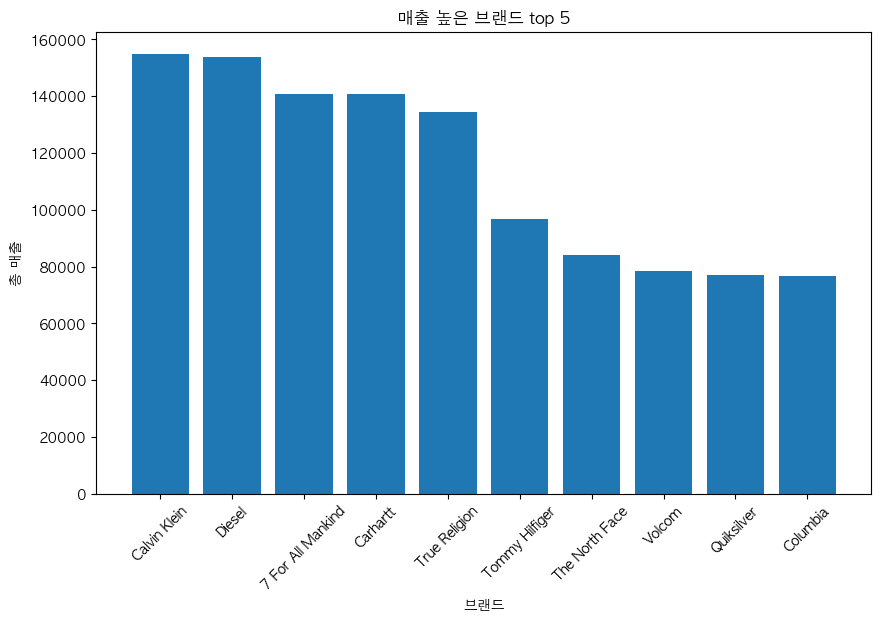

In [59]:
# top performers 시각화

plt.figure(figsize=(10,6))
plt.bar(top_performers['brand'], top_performers['sale_price'])
plt.xlabel('브랜드')
plt.ylabel('총 매출')
plt.xticks(rotation=45)
plt.title('매출 높은 브랜드 top 5')
plt.show()

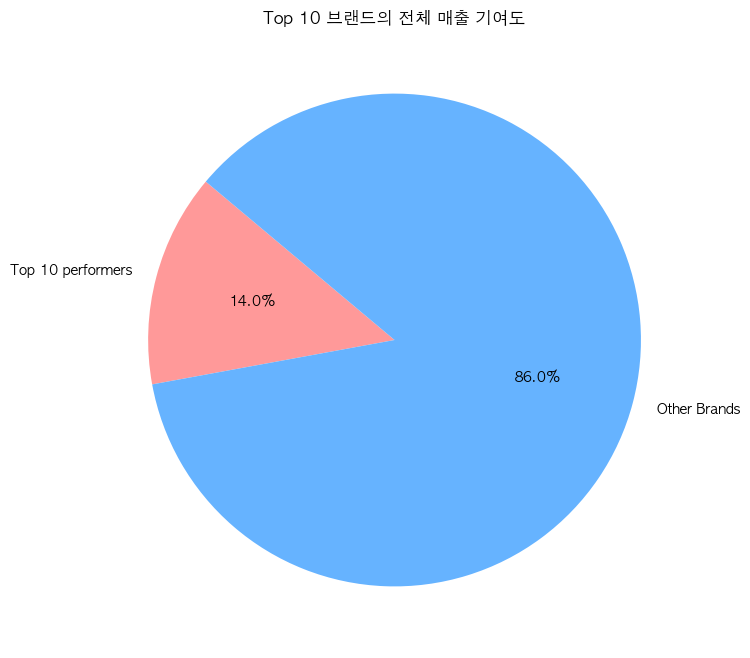

In [62]:
total_top_performers_profit = top_performers['sale_price'].sum()

top_performers_brands = top_performers['brand'].tolist()
other_company_profits = orders_complete_merged.loc[~orders_complete_merged['brand'].isin(top_performers_brands), 'sale_price'].sum()
combined_top_performers = pd.DataFrame({'brand':['Top 10 performers', 'Other Brands'], 'sales' : [total_top_performers_profit, other_company_profits]})


# 시각화
labels = combined_top_performers['brand']
sizes = combined_top_performers['sales']

colors = ['#ff9999','#66b3ff']

# 파이 차트 생성
plt.figure(figsize=(8, 8))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
plt.title('Top 10 브랜드의 전체 매출 기여도')
plt.show()


In [72]:
category_performance = orders_complete_merged.groupby('category')[['profit', 'sale_price', 'cost']].sum().reset_index()
top_cat_performers = category_performance.sort_values(by='sale_price', ascending=False).head()

print(top_cat_performers)

                         category         profit     sale_price           cost
11              Outerwear & Coats  545698.966501  983391.899374  437692.932873
7                           Jeans  437515.226906  941800.611532  504285.384626
22                       Sweaters  330424.016536  637020.430201  306596.413664
21            Suits & Sport Coats  297924.553950  497929.799460  200005.245510
5   Fashion Hoodies & Sweatshirts  234634.394687  488461.310351  253826.915664


/var/folders/qv/tqmmyp0s5dj996k_tcvqmtqm0000gn/T/ipykernel_2983/647247920.py:1: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



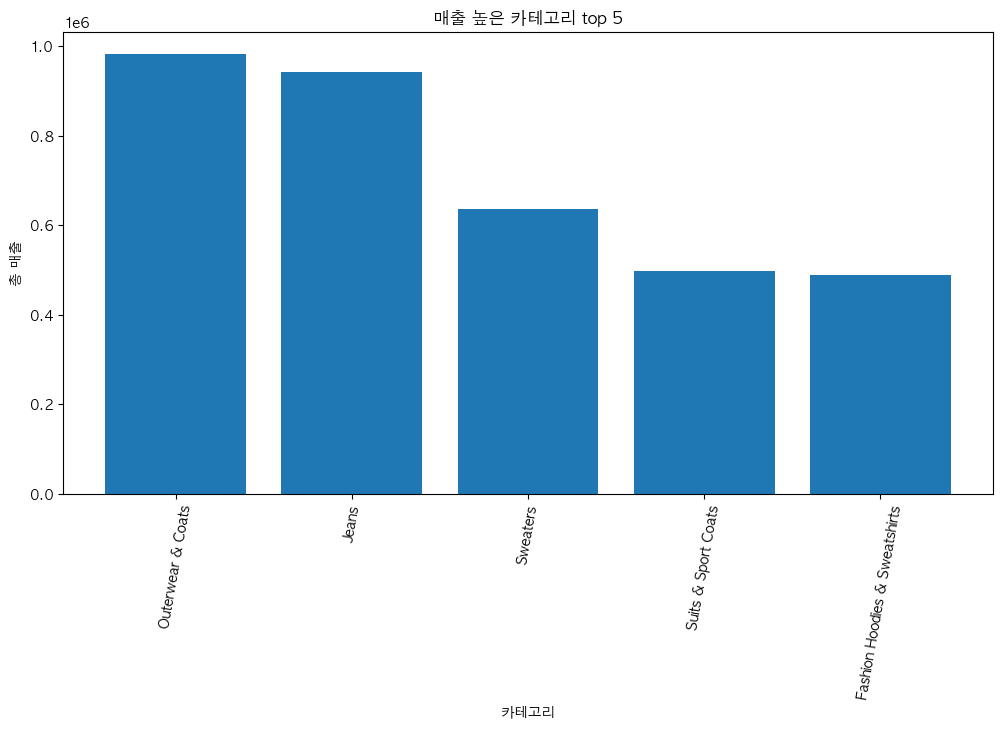

In [73]:
# top_cat_performers 시각화 

plt.figure(figsize=(12,6))
plt.bar(top_cat_performers['category'], top_cat_performers['sale_price'])
plt.xlabel('카테고리')
plt.ylabel('총 매출')
plt.xticks(rotation=80)
plt.title('매출 높은 카테고리 top 5')
plt.show()

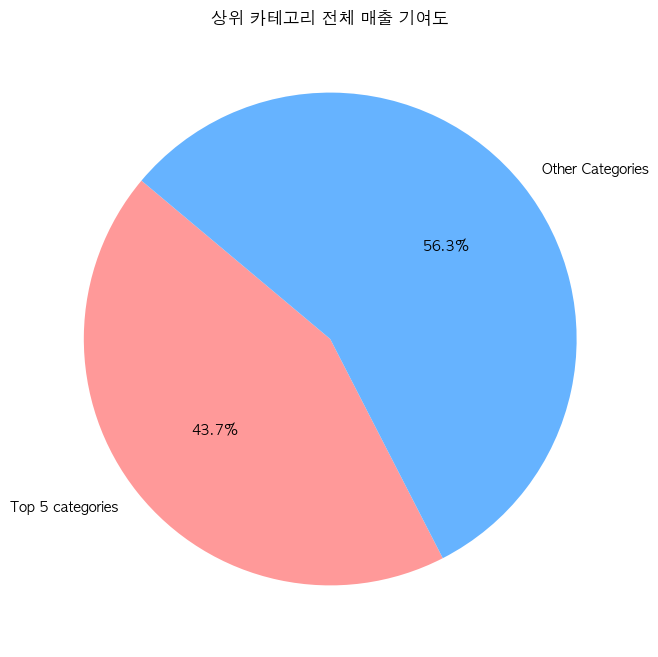

In [76]:
total_top_category_performance = top_cat_performers['sale_price'].sum()

top_cat_performers_list = top_cat_performers['category'].tolist()
other_cat_performance = orders_complete_merged.loc[~orders_complete_merged['category'].isin(top_cat_performers_list), 'sale_price'].sum()
combined_top_cat_performers = pd.DataFrame({'category': ['Top 5 categories', 'Other Categories'], 'sales': [total_top_category_performance, other_cat_performance]})


# 시각화
labels = combined_top_cat_performers['category']
sizes = combined_top_cat_performers['sales']

colors = ['#ff9999','#66b3ff']

# 파이 차트 생성
plt.figure(figsize=(8, 8))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
plt.title('상위 카테고리 전체 매출 기여도')
plt.show()


In [45]:
popular_products = orders_complete_merged.groupby(['category', 'name'])['num_of_item'].sum().reset_index()
top_10_products = popular_products.sort_values(by='num_of_item', ascending=False).head(10)

top_10_products

/var/folders/qv/tqmmyp0s5dj996k_tcvqmtqm0000gn/T/ipykernel_2983/3862366258.py:1: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



,category,name,num_of_item
215661,Jeans,Wrangler Men's Premium Performance Cowboy Cut ...,93
189769,Jeans,7 For All Mankind Men's Standard Classic Strai...,61
203144,Jeans,Kenneth Cole Men's Straight Leg Jean,53
215660,Jeans,Wrangler Men's Original Cowboy Cut Relaxed Fit...,52
470615,Sleep & Lounge,HUGO BOSS Men's Long Pant,51
213670,Jeans,True Religion Men's Ricky Straight Jean,50
214735,Jeans,Volcom Men's Vorta Slim Straight Leg Fit Jean,47
215675,Jeans,Wrangler Men's Rugged Wear Classic Fit Jean,46
672919,Tops & Tees,Tommy Hilfiger Men Custom Fit Plaid Short Slee...,45
420784,Shorts,Lilly Pulitzer Women's Callahan Short,44


In [46]:
# top_10_products 시각화..?

In [47]:
orders_complete_merged.columns

Index(['id_x', 'order_id', 'user_id', 'product_id', 'inventory_item_id',
       'status', 'created_at', 'shipped_at', 'delivered_at', 'returned_at',
       'sale_price', 'id_y', 'cost', 'category', 'name', 'brand',
       'retail_price', 'department', 'sku', 'distribution_center_id',
       'num_of_item', 'profit'],
      dtype='object')

In [48]:
#Grouping By Year
grouped_by_year = orders_complete_merged.groupby(orders_complete_merged['delivered_at'].dt.date)[['profit', 'sale_price', 'cost']].sum().reset_index()

#Creating a seven day rolling average
for column in ['profit', 'sale_price', 'cost']:
    grouped_by_year[column+'_7day_avg'] = grouped_by_year[column].rolling(window=7).mean()
grouped_by_year = grouped_by_year.dropna()

fig = px.line(grouped_by_year,
              x='delivered_at',
              y=['profit_7day_avg', 'sale_price_7day_avg', 'cost_7day_avg'],
              hover_data={'delivered_at': '|%d-%b-%Y'},
              labels=dict(value='$',
                          delivered_at='Date',
                          variable='Metric'))

fig.show()

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed